In [1]:
import numpy as np
import pandas as pd

In [2]:
from Function_readLabChartMat import get_pages_data, backRMS, autoEventDetection, manualEventDetect, avgVals

In [3]:
ptID = "EPD12" 
#ptID = "default_value" 

In [4]:
# generating inputs and creating the path
import os
cmnPath = r'R:\Prosjekter\ELECTROPHYSIOLOGY_PD_1000214'


if ptID.startswith('EHC'):
    grp = 'HealthyControl'
elif ptID.startswith('EPD'):
    grp ='ParkinsonsDisease'


In [6]:
# creating path based on the inputs and changing the working director
filePath = os.path.join(cmnPath,grp,ptID)
os.chdir(filePath)

# locating the excel file 
xlFile = [f for f in os.listdir() if f.endswith('.xlsx') and f.startswith(ptID)]
print(xlFile)

xlPath = os.path.join(filePath,xlFile[0])
print(xlPath)


['EPD12_24042024_Analysis.xlsx']
R:\Prosjekter\ELECTROPHYSIOLOGY_PD_1000214\ParkinsonsDisease\EPD12\EPD12_24042024_Analysis.xlsx


In [7]:
# importing data from excel file
#READING EXCEL FILE
    
xlData = pd.ExcelFile(xlPath)     
xlDF = pd.read_excel(xlData,sheet_name="H-reflex")
 

In [8]:
# this is how  you can access to specific sheet of excel 
    # so, reading the entire excel sheet first and storing its information will be more efficient
# Display the indices (as a list of (row, column) tuples)

fileName_HMCurve = xlDF.iloc[13,1]
fileName_HMCurve = fileName_HMCurve + ".mat"
print(fileName_HMCurve)
fileName_shortTrials = xlDF.iloc[19,1]
fileName_shortTrials = fileName_shortTrials + ".mat"
print(fileName_shortTrials)
fileName_longTrials = xlDF.iloc[24,1]
fileName_longTrials = fileName_longTrials + ".mat"
print(fileName_longTrials)


EPD12_HMCurve_5trials_04112024.mat
EPD12_ShortTrial_15trials_04112024.mat
EPD12_LongTrial_40trials_04112024.mat


In [9]:
filename = os.path.join(filePath,fileName_shortTrials)
preTrigger = 50 #time in msec
postTrigger = 100 #time in msec
samp_rate = 4000
pre_time_ms = 50 
post_time_ms = 100
avgFact = 15

In [10]:
# calling function to obtain the pages
pages = get_pages_data(filename, samp_rate, pre_time_ms, post_time_ms, avgFact)
len(pages[0])


9

Text(0.5, 0, 'Time(ms)')

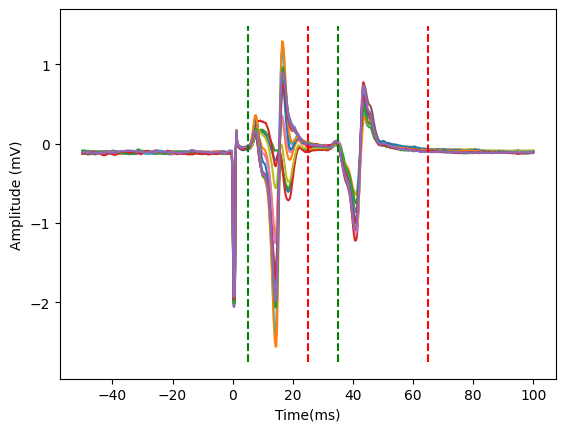

In [11]:
chNo = 1
import matplotlib.pyplot as plt

timeAxis = np.linspace(-pre_time_ms,post_time_ms,len(pages[0][0]))

hOnset_ms = 35
mOnset_ms = 5
hrangeTime_ms = 30
mrangeTime_ms = 20

for pg in range(len(pages)): 
    plt.plot(timeAxis,(pages[pg][chNo-1]*1000))
ymin, ymax = plt.ylim()
plt.vlines(x=[hOnset_ms, mOnset_ms], ymin=ymin, ymax=ymax, colors='green', linestyles='dashed', label='vlines')
plt.vlines(x=[hOnset_ms+hrangeTime_ms, mOnset_ms+mrangeTime_ms], ymin=ymin, ymax=ymax, colors='r', linestyles='dashed', label='vlines')
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time(ms)")


In [ ]:
HAmplitudes_mV = []
MAmplitudes_mV = []
for pgNo in range(len(pages)):
    indEpoch = pages[pgNo][chNo-1]
    hmSignal = manualEventDetect(indEpoch, pre_time_ms, samp_rate, hOnset_ms, mOnset_ms, hrangeTime_ms,mrangeTime_ms)
    hAmp = round((max(hmSignal[0]) - min(hmSignal[0]))*1000,3)
    HAmplitudes_mV.append(hAmp)
    mAmp = round((max(hmSignal[1]) - min(hmSignal[1]))*1000,3)
    MAmplitudes_mV.append(mAmp)

[np.float64(1.706), np.float64(1.615), np.float64(1.361), np.float64(1.996), np.float64(1.57), np.float64(1.815), np.float64(1.844), np.float64(1.406), np.float64(1.707), np.float64(1.048), np.float64(1.622), np.float64(0.986), np.float64(1.198), np.float64(1.579), np.float64(1.822)]


In [14]:
# extracting backRMS values and preparing it by average of certain values
RMS_Signal_StartTime_ms = 50
RMS_Signal_EndTime_ms = 1
RMS_samp_rate = samp_rate
RMS_pre_time_ms = pre_time_ms

RMS_signalArray = []
Pages_backrms = get_pages_data(filename, samp_rate, pre_time_ms, post_time_ms, avgFact = 1)
BackgroundRMS_mv = []
for pgNo_rms in range(len(Pages_backrms)):
    indEpoch_rms = Pages_backrms[pgNo_rms][chNo-1]
    RMS_signal = backRMS(indEpoch_rms, RMS_Signal_StartTime_ms, RMS_Signal_EndTime_ms, RMS_samp_rate, RMS_pre_time_ms)
    # removing DC offset
    RMS_noDCOffset = RMS_signal - np.mean(RMS_signal)
    RMS_signalArray.append(RMS_noDCOffset)
    rmsVal = round(np.sqrt(np.mean(RMS_noDCOffset**2))*1000,3)
    BackgroundRMS_mv.append(rmsVal)

# averaging by avgFact
avgBackgroundRMS_mV = avgVals(BackgroundRMS_mv, avgFact)
avgBackgroundRMS_mV = [round(num,3) for num in avgBackgroundRMS_mV]

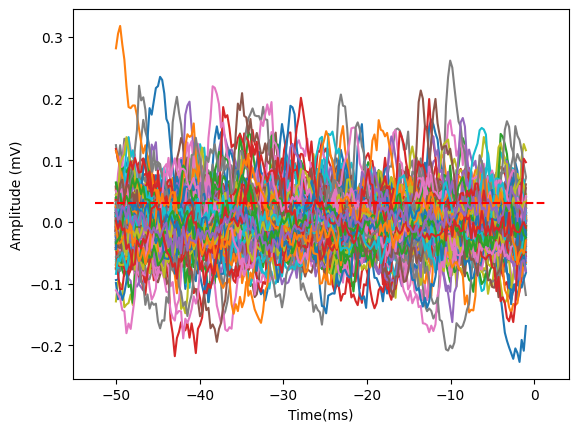

In [15]:
# Plotting the background RMS
RMS_timeax = np.linspace(-RMS_Signal_StartTime_ms, -RMS_Signal_EndTime_ms, len(RMS_signalArray[0]))

for RMS_no in range(len(RMS_signalArray)):
    plt.plot(RMS_timeax, RMS_signalArray[RMS_no]*1000)
plt.ylabel("Amplitude (mV)")
plt.xlabel("Time(ms)")
xmin, xmax = plt.xlim()

plt.hlines(y=np.average(avgBackgroundRMS_mV), xmin=xmin, xmax=xmax, color='red', linestyle='--', label='y = 0.5')


In [16]:
# creating a df to be exported as excel file
partiID =  [ptID] * len(HAmplitudes_mV)
group = [grp] * len(HAmplitudes_mV)
trialOrder = list(range(1,len(HAmplitudes_mV)+1))
dict_outcome = {"ParticipantID": partiID, "Group": grp, "TrialOrder": trialOrder,"HAmplitudes_mV": HAmplitudes_mV, "MAmplitudes_mV": MAmplitudes_mV, "avgBackgroundRMS_mV":avgBackgroundRMS_mV}
df_output = pd.DataFrame(dict_outcome)

In [17]:
# reading conditions from XL
df_frmXL = pd.read_excel(xlData,sheet_name="Standing (ShortTrials)", usecols="A:B", skiprows=8, nrows=15)
df_frmXL.rename(columns={df_frmXL.columns[0]: 'TrialOrder', df_frmXL.columns[1]: 'Condition'}, inplace=True)
EOpen = df_frmXL['Condition'].str.contains('Open', case=False, na=False)
SurfaceFirm = df_frmXL['Condition'].str.contains('Firm', case=False, na=False)
DualTask = df_frmXL['Condition'].str.contains('DT', case=False, na=False)

#creating complexity
complexity_mapping = {
    'Eyes Open Firm': 1,
    'Eyes Open Foam': 3,
    'Eyes Closed Firm': 2,
    'Eyes Closed Foam': 4,
    'Eyes Closed Foam DT': 5
}

# Create the 'complexity' column by mapping the values in the existing column
Complexity = df_frmXL['Condition'].map(complexity_mapping) 

dict_forXL = {"ParticipantID": partiID, "EOpen": EOpen.astype(int), "SFirm":SurfaceFirm.astype(int), 
              "DTask": DualTask.astype(int), "Complexity": Complexity.astype(int)}
df_XLCombined = df_frmXL.assign(**dict_forXL)


In [18]:
merged_df = pd.merge(df_XLCombined,df_output, on=['ParticipantID', 'TrialOrder'])
merged_df = merged_df.sort_values(by='TrialOrder', ascending=True)
merged_df['Timestamp'] = pd.Timestamp('now').floor('s')
print(merged_df)


    TrialOrder            Condition ParticipantID  EOpen  SFirm  DTask  \
0            1     Eyes Closed Firm         EPD12      0      1      0   
1            2       Eyes Open Foam         EPD12      1      0      0   
2            3       Eyes Open Firm         EPD12      1      1      0   
3            4     Eyes Closed Firm         EPD12      0      1      0   
4            5  Eyes Closed Foam DT         EPD12      0      0      1   
5            6     Eyes Closed Foam         EPD12      0      0      0   
6            7       Eyes Open Firm         EPD12      1      1      0   
7            8  Eyes Closed Foam DT         EPD12      0      0      1   
8            9       Eyes Open Firm         EPD12      1      1      0   
9           10       Eyes Open Foam         EPD12      1      0      0   
10          11     Eyes Closed Firm         EPD12      0      1      0   
11          12       Eyes Open Foam         EPD12      1      0      0   
12          13     Eyes Closed Foam   

In [19]:
from openpyxl import load_workbook

saveXLSwitch = 1
if saveXLSwitch == 1:
    XLoutput_file = r'R:\Prosjekter\ELECTROPHYSIOLOGY_PD_1000214\newDatafromPython.xlsx'
    #merged_df.to_excel(XLoutput_file, index=False, sheet_name='Merged Data')
    xlLoaded = load_workbook(XLoutput_file)

    with pd.ExcelWriter(XLoutput_file, mode='a', engine='openpyxl', if_sheet_exists='overlay') as writer:
        writer.xlLoaded = xlLoaded
        # The name of the sheet you want to append to
        sheet_name = 'Merged Data'
        
        # Get the max row in the existing sheet
        startrow = writer.sheets[sheet_name].max_row
        # Append the DataFrame to the sheet
        merged_df.to_excel(writer, sheet_name=sheet_name, startrow=startrow, index=False, header=True)

    print("Data added to the file",XLoutput_file)


Data added to the file R:\Prosjekter\ELECTROPHYSIOLOGY_PD_1000214\newDatafromPython.xlsx


# run this pipeline in a separate notebook for multiple inputs for the participant ID
import papermill as pm
# List of patient IDs
# patient_ids = ["EHC01", "EHC02", "EHC04", "EHC05", "EHC06"]  # add as many as needed
patient_ids = ["EPD01", "EPD02", "EPD03", "EPD04", "EPD06", "EPD07", "EPD08", "EPD09", "EPD10", "EPD11"]


# Execute the notebook for each patient ID
for pt_id in patient_ids:
    pm.execute_notebook(
        'Pipeline_HMAnalysis.ipynb',               # Path to your input notebook
        f'output_notebook_{pt_id}.ipynb',       # Save each output with the patient ID
        parameters={'ptID': pt_id}              # Pass ptID as a parameter
    )